### CNN/DailyMail Dataset 을 이용한 summarization

In [38]:
from datasets import load_dataset

dataset = load_dataset("cnn_dailymail", '3.0.0')

In [39]:
dataset["train"].features

{'article': Value(dtype='string', id=None),
 'highlights': Value(dtype='string', id=None),
 'id': Value(dtype='string', id=None)}

In [40]:
dataset["train"][10]["article"][:2000]
summarys = {}

### nltk, sent tokenize

In [41]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/tommy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [42]:
import nltk
nltk.data.path.append('/usr/local/share/nltk_data')

# 'punkt' 다운로드 및 찾기
nltk.download('popular')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /home/tommy/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /home/tommy/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /home/tommy/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /home/tommy/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /home/tommy/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /home/tommy/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!

True

### 요약 모델의 baseline
- 주로 요약 모델의 baseline **첫 문장 3개**

In [43]:
test = dataset["train"][10]["article"][:2000]

sent_tokenize(test)[:3] # sentance spliting

['WASHINGTON (CNN) -- As he awaits a crucial progress report on Iraq, President Bush will try to put a twist on comparisons of the war to Vietnam by invoking the historical lessons of that conflict to argue against pulling out.',
 'President Bush pauses Tuesday during a news conference at the  North American Leaders summit in Canada.',
 'On Wednesday in Kansas City, Missouri, Bush will tell members of the Veterans of Foreign Wars that "then, as now, people argued that the real problem was America\'s presence and that if we would just withdraw, the killing would end," according to speech excerpts released Tuesday by the White House.']

### str + "TL;DR"
- too long didn't read
- 한국어 버젼으로 "3 줄 요약좀.."

### gpt2 for summarization

In [ ]:
from transformers import pipeline, set_seed


set_seed(42)
pipe = pipeline("text-generation", model="gpt2-xl")
query = test + "\nTL;DR\n"
pip_out = pipe(query, max_length = 512, clean_up_tokenization_spaces = True)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


In [ ]:
summarys["gpt2"] = pip_out[0]["generated_text"].split("\nTL;DR\n")[-1]

### T5 for summarization

In [ ]:
pipe = pipeline("summarization", model="t5-large")
pip_out = pipe(test)
summarys["t5"]=pip_out[0]["summary_text"]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
summarys

{'gpt2': "To be fair, you can't compare this war to prior conflicts in east Asia in the sense that there's a difference between military intervention and war. Also, the president's speech excerpts are not necessarily a full transcript. The White House says it will release the full remarks sometime in the next 2-3 days.",
 't5': 'president bush will try to put a twist on comparisons of the war to Vietnam . he\'ll tell veterans of foreign war that "the real problem was America\'s presence" "the price of america\'s withdrawal was paid by millions of innocent citizens" speech excerpts released by the white house .'}

### BART for summarization

In [ ]:
pipe = pipeline("summarization", model="facebook/bart-large-cnn", device="cuda")
pip_out = pipe(test)
summarys["bart"]=pip_out[0]["summary_text"]

In [ ]:
summarys

{'gpt2': "To be fair, you can't compare this war to prior conflicts in east Asia in the sense that there's a difference between military intervention and war. Also, the president's speech excerpts are not necessarily a full transcript. The White House says it will release the full remarks sometime in the next 2-3 days.",
 't5': 'president bush will try to put a twist on comparisons of the war to Vietnam . he\'ll tell veterans of foreign war that "the real problem was America\'s presence" "the price of america\'s withdrawal was paid by millions of innocent citizens" speech excerpts released by the white house .',
 'bart': "President Bush to tell Veterans of Foreign Wars about Vietnam War. He will argue withdrawal from Vietnam emboldened terrorists, he will say. Bush will cite Osama bin Laden's quote that U.S. would rise against Iraq war. Senate Majority Leader Harry Reid says comparison ignores difference between wars."}

### PEGASUS for summarization

In [ ]:
pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail", device="cuda")
pip_out = pipe(test)


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
summarys["pegasus"]=pip_out[0]["summary_text"].replace('<n>','')

### 모델별 비교

In [ ]:
print("[grund truth]")
print(dataset["test"][10]["article"],'\n')

for k,v in summarys.items():
    print(f"[{k}]")
    print(v, end="\n\n")

[grund truth]
London (CNN)A 19-year-old man was charged Wednesday with terror offenses after he was arrested as he returned to Britain from Turkey, London's Metropolitan Police said. Yahya Rashid, a UK national from northwest London, was detained at Luton airport on Tuesday after he arrived on a flight from Istanbul, police said. He's been charged with engaging in conduct in preparation of acts of terrorism, and with engaging in conduct with the intention of assisting others to commit acts of terrorism. Both charges relate to the period between November 1 and March 31. Rashid is due to appear in Westminster Magistrates' Court on Wednesday, police said. CNN's Lindsay Isaac contributed to this report. 

[gpt2]
To be fair, you can't compare this war to prior conflicts in east Asia in the sense that there's a difference between military intervention and war. Also, the president's speech excerpts are not necessarily a full transcript. The White House says it will release the full remarks so

### 모델 평가 (BLEU:Bilingual Evaluation Understudy Score)
- 참조 텍스트와 얼마나 많이 정렬되었는지, 단어 or n-gram 을 체크 (:정밀도 에서 비롯된 방법)
    - 수정 정밀도($p_n$) 공식
        $$ p_n = \frac{\sum_{\text{n-gram} \in snt'}Count_{\text{clip}}(\text{n-gram})}{\sum_{\text{n-gram} \in snt}Count(\text{n-gram})}$$
        에서<br>
            $snt$ : **gen** 된 (후보)candidate 문장 <br>
            $snt'$ : 참조(reference) 문장 <br>
            $\text{n-gram}$ : 연속된 단어의 조합 <br>
            $Count_{\text{clip}}(\text{n-gram})$ : 클리핑 된 $\text{n-gram}$ 의 수(겹치는 $\text{n-gram}$)<br>
            $Count(\text{n-gram})$ : 생성된 문장의 $\text{n-gram}$ 갯수 <br>
    - 예시 (1-gram)
        - ref = "the cat is on the mat"
        - gen = "<u>the</u> the the the <u>the</u> the"

        $$  P_{n} = \frac{\text{문장 일치수}}{\text{생성된 총 단어 수}} =  \frac{2}{6}$$

    - 재현 률을 고려한 항 **BR(brevity penalty)** : 즉 생성된 문장이 참조 문장보다 짧은지의 척도, 생성된 문장이 길면 $BR = 1$ 이다
        $$BR = \min(1, e^{1-l_{\text{ref}}/l_{\text{gen}}})$$
        - 결과 길이를 고려한 항,
        - 번역 길이가 짧은경우 P 값이 상승하는 경향이 있어
        - 길이가 짧을 경우 패널티를 준다.
        - 생성된 길이가 참조 문장보다 길면 1로 반환 한다.
    - BLEU-N 점수 계산
        - 수정 정밀도의 기하평균 : $$\left(\prod_{n=1}^{N} p_n\right)^{1/N} == \exp{\left(\frac{1}{N}\prod_{n=1}^{N} \log p_n \right)}$$
        - BLEU-N 점수 계산 : $$\text{BLEU-N} = \text{BR} \times \left(\prod_{n=1}^{N} p_n\right)^{1/N}$$
- 단점 : 
    - **동의어를** 고려하지 않음
    - **토큰화된 텍스트**를 기대한다. <br>
        ex.<br>
        reference : [I'm a doctor] -> ['I',"'",'m',' a','doctor']<br>
        candidate : [I am a doctor] -> ['I',' am',' a','doctor']<br>
        에서 I'm 과 I am 은 동의어로 치부하지 않게 된다. 또한 토큰 길이도 다르게 될 수 있어 이에 대한 패널티를 얻을 수 있다.

In [ ]:
# !pip install evaluate
# !pip install rouge_score

$$\text{BLEU-N} = \text{BR} \times \left(\prod_{n=1}^{N} p_n\right)^{1/N}$$

In [ ]:
# 1-gram test
import evaluate
bleu= evaluate.load("bleu")


ref = "the cat is on the mat"
can = "the the the the the the"

b_result =bleu.compute(predictions=[can], references=[ref])
print(b_result)

{'bleu': 0.0, 'precisions': [0.3333333333333333, 0.0, 0.0, 0.0], 'brevity_penalty': 1.0, 'length_ratio': 1.0, 'translation_length': 6, 'reference_length': 6}


In [ ]:
#n-gram test
bleu= evaluate.load("bleu")

ref = "the cat is on the mat"
# can = "the the the the the the"
can_for_2_gram = "the cat the the the is on the mat mat mat mat"

b_result =bleu.compute(predictions=[can_for_2_gram], references=[ref], max_order = 2) # max_order 로 n-gram 을 정해준다.
for f,(k,v) in zip(["BLEU-N","p","BP", "BR","len_gen","len_ref"],b_result.items()):
    print(f"{f:20s}({k:20s}):{v}")

print("""
생성된 문장의 길이가 참조 문장보다 길다.
BR => 1 로 계산된다
""")

BLEU-N              (bleu                ):0.4264014327112209
p                   (precisions          ):[0.5, 0.36363636363636365]
BP                  (brevity_penalty     ):1.0
BR                  (length_ratio        ):2.0
len_gen             (translation_length  ):12
len_ref             (reference_length    ):6

생성된 문장의 길이가 참조 문장보다 길다.
BR => 1 로 계산된다



In [ ]:
# !pip install sacrebleu

In [ ]:
# Sacre bleu : 토큰화 단계를 내제화

sacrebleu = evaluate.load("sacrebleu")

sb_result = sacrebleu.compute(predictions=[can_for_2_gram], references=[ref])
sb_result

{'score': 25.211936184349828,
 'counts': [6, 4, 2, 1],
 'totals': [12, 11, 10, 9],
 'precisions': [50.0, 36.36363636363637, 20.0, 11.11111111111111],
 'bp': 1.0,
 'sys_len': 12,
 'ref_len': 6}

### 모델 평가 (ROUGE:Recall-Oriented Understudy for Gisting Evaluation)
- ROUGE-N Recall(참조 문장) 기반 $$ \text{ROUGE-N} = \frac{\sum_{\text{n-gram} \in \text{ref}} \min(\text{Count}_{\text{gen}}(\text{n-gram}), \text{Count}_{\text{ref}}(\text{n-gram}))}{\sum_{\text{n-gram} \in \text{ref}} \text{Count}_{\text{ref}}(\text{n-gram})}$$
    $$ \frac{\text{모든 참조 문장의 <n-gram과 생성문장의 n-gram 중 최솟값 들>의 합}}{\text{모든 참조 문장의 <n-gram 의 경우의 수>의 합}}$$

- ROUGE-N Precision (생성된 문장) 기반 $$ \text{ROUGE-N} = \frac{\sum_{\text{n-gram} \in \text{gen}} \min(\text{Count}_{\text{gen}}(\text{n-gram}), \text{Count}_{\text{ref}}(\text{n-gram}))}{\sum_{\text{n-gram} \in \text{gen}} \text{Count}_{\text{gen}}(\text{n-gram})}$$

- ROUGE-N f-1 score $$ \text{f1-score} = \frac{2 \times \text{precision} \times \text{recall}}{\text{preciaion} + \text{recall}}$$

    > BLUE 와의 비교 $$\text{BLEU-N} = \min(1, e^{1-l_{\text{ref}}/l_{\text{gen}}}) \times \prod_{n=1}^{N} \left( \frac{\sum_{\text{n-gram} \in snt'}Count_{\text{clip}}(\text{n-gram})}{\sum_{\text{n-gram} \in snt}Count(\text{n-gram})} \right)^{1/N}$$

- ROUGE-L
    - LCS 점수 (Longest Common Subsequence : 가장 긴 공통 시퀀스)
        - 문자열 기준 에서 비교가 가능 ("<u>appl</u>e" and "<u>appl</u>ication")
        - $\text{X} = \text{*appl*e}$ 와 $\text{Y} = \text{*appl*ication}$ 에서
          $$\text{LCS(X,Y)} = 4$$
          $$R_{\text{LCS}} = \frac{\text{LCS(X,Y)}}{m} = \frac{4}{5}$$
          $$P_{\text{LCS}} = \frac{\text{LCS(X,Y)}}{n} = \frac{4}{11}$$
          $$F_{\text{LCS}} = \frac{(1 + \beta^2) R_{\text{LCS}} P_{\text{LCS}}}{R_{\text{LCS}} + P_{\text{LCS}}}$$
            - 만약 $\beta = 1$ 일때 기존 **f1-score** 공식이랑 동일 <br>(`transformer` 는 $\beta = 1$ 로 계산)

- meteor 및 rouge

In [ ]:
rouge = evaluate.load("rouge")

r_result = rouge.compute(predictions=[can], references=[ref])
print("ROUGE")
print(r_result)

ROUGE
{'rouge1': 0.3333333333333333, 'rouge2': 0.0, 'rougeL': 0.3333333333333333, 'rougeLsum': 0.3333333333333333}


In [ ]:
import pandas as pd
all_scores = {}

for k,v in summarys.items():
    scores = rouge.compute(references=[dataset["test"][10]["article"]],predictions=[v])
    all_scores[k] = scores

display(pd.DataFrame(all_scores).T)
"전반적으로 pegasus 의 성능이 좋다"

,rouge1,rouge2,rougeL,rougeLsum
gpt2,0.160920,0.000000,0.080460,0.080460
t5,0.179641,0.000000,0.107784,0.107784
bart,0.096386,0.000000,0.072289,0.072289
pegasus,0.134228,0.013605,0.080537,0.080537


'전반적으로 pegasus 의 성능이 좋다'

- 참고 meteor 스코어 $$\text{METEOR} = \frac{10 \times \text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} \times \left(1 - \frac{\text{Penalty}}{\text{len}} \right)$$

    여기서
    $$\text{Precision} = \frac{\text{LCS}(X,Y)}{m}$$
    $$\text{Recall} = \frac{\text{LCS}(X,Y)}{n}$$
    $$\text{Penalty} = n_{\text{chunk}} - 1$$
    - chunk 의 기준
        - 생성문, 참조문 단어 순서 일치 부분
        - 완전히 일치하는 경우 패널티 = 0
        - 일치하는 chunk 가 많아 질 수록 패널티 증가
        - 즉 순서차이가 큰 문장에서 패널티 증가

In [ ]:
metero = evaluate.load("meteor")
m_result = metero.compute(predictions=[can], references=[ref])
print("*"*200)
print(m_result)

[nltk_data] Downloading package wordnet to /home/tommy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/tommy/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/tommy/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


********************************************************************************************************************************************************************************************************
{'meteor': 0.16666666666666666}


In [ ]:
can

'the the the the the the'

### PEGASUS 모델 평가

In [45]:
from datasets import load_dataset

dataset = load_dataset("cnn_dailymail", '3.0.0')

In [46]:
test_data = dataset["test"].shuffle(seed=42).select(range(1800))
test_data = test_data.map(lambda x: {"article": x["article"][:2000]}) # 너무 길어서 글자수 제한
test_data = test_data.map(lambda x: {"three_sentence_summaries": ".".join(x["article"].split(".")[:3])}) # 베이스 라인 모델 : 처음 3개의 문장 (요약)

In [ ]:
# test_data["article"]

In [47]:
from transformers import pipeline
from tqdm import tqdm

# Pegasus 모델 로드
pegasus = pipeline("summarization", model="google/pegasus-cnn_dailymail", device=0)


def predict_pegasus_batch(batch):
    summaries = pegasus(batch["article"])
    batch["summary_text"] = [summary["summary_text"] for summary in summaries]
    return batch

# 데이터 배치 크기 설정
batch_size = 300

# 배치 처리
batched_results = []
for i in tqdm(range(0, len(test_data), batch_size)):
    batch = test_data[i:i+batch_size]
    batched_results.append(predict_pegasus_batch(batch))

final_results = {}

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 6/6 [1:11:28<00:00, 714.82s/it]


In [48]:
# 결과 병합
for key in batched_results[0].keys():
    inst_list =[]
    for i in range(len(batched_results)):
        inst_list.append(batched_results[i][key])
    final_results[key] = inst_list

In [27]:
import evaluate

def eval_rouge(preds, refs):
    rouge = evaluate.load("rouge")
    rouge.add_batch(predictions=preds, references=refs)
    r_result = rouge.compute()
    return r_result

In [49]:
three_sentence_summaries_ = [i[0].replace("\n"," ") for i in final_results["three_sentence_summaries"]]
summary_text_ = [i[0].replace("\n"," ") for i in final_results["summary_text"]]
highlights_ = [i[0].replace("\n"," ") for i in final_results["highlights"]]

In [50]:
import pandas as pd

pd.DataFrame(data=[eval_rouge(three_sentence_summaries_, highlights_),
                   eval_rouge(summary_text_, highlights_)],
            index=["baseline", "pegasus"])

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.338175,0.166377,0.227477,0.227477
pegasus,0.384581,0.207907,0.290122,0.290222


- Rouge 점수는 일정수준 정확도와 관련이 없다.
- Rouge 점수는 디코딩 전략과 관련이 있다.
- Rouge 와 Bleu 점수보다는 사람의 판단이 더욱 중요하다.

### 삼성의 SAMsum Dataset

- 삼성의 데이터셋 이용 ([SAMsum dataset](https://huggingface.co/datasets/Samsung/samsum))

In [7]:
# !pip install py7zr : 7z 압축 파일 라이브러리

In [51]:
from datasets import load_dataset

samsum_dataset = load_dataset("samsum")
samsum_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

In [52]:
print(samsum_dataset["train"][5]["dialogue"])
print("*"*50)
print(samsum_dataset["train"][5]["summary"])

Neville: Hi there, does anyone remember what date I got married on?
Don: Are you serious?
Neville: Dead serious. We're on vacation, and Tina's mad at me about something. I have a strange suspicion that this might have something to do with our wedding anniversary, but I have nowhere to check.
Wyatt: Hang on, I'll ask my wife.
Don: Haha, someone's in a lot of trouble :D
Wyatt: September 17. I hope you remember the year ;)
**************************************************
Wyatt reminds Neville his wedding anniversary is on the 17th of September. Neville's wife is upset and it might be because Neville forgot about their anniversary.


In [5]:
from transformers import pipeline

pegasus = pipeline("summarization", model="google/pegasus-cnn_dailymail", device=0);
test_result = pegasus(samsum_dataset["test"][5]["dialogue"])

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
ref = samsum_dataset["train"][5]["summary"]
pre = test_result[0]["summary_text"].replace("<n>","\n")
print("reference : \n")
print(ref)
print("*"*50)
print("prediction with no train : \n")
print(pre)

reference : 

Wyatt reminds Neville his wedding anniversary is on the 17th of September. Neville's wife is upset and it might be because Neville forgot about their anniversary.
**************************************************
prediction with no train : 

Benjamin and Hilary are having lunch with some French people .
Then they'll head to La Cantina for some Italian cuisine .
And then they'll take the keys and take a nap .


In [7]:
import evaluate

rouge = evaluate.load("rouge")

r_result = rouge.compute(predictions=[pre], references=[ref])
print("ROUGE")
print(r_result)

ROUGE
{'rouge1': 0.06779661016949153, 'rouge2': 0.0, 'rougeL': 0.06779661016949153, 'rougeLsum': 0.06779661016949153}


### PEGASUS 파인튜닝

1. 입출력 길이 분포 확인

In [8]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("google/pegasus-cnn_dailymail")
dia_lens = [len(tokenizer.encode(i)) for i in samsum_dataset["train"]["dialogue"]]
sum_lens = [len(tokenizer.encode(i)) for i in samsum_dataset["train"]["summary"]]

Token indices sequence length is longer than the specified maximum sequence length for this model (1044 > 1024). Running this sequence through the model will result in indexing errors


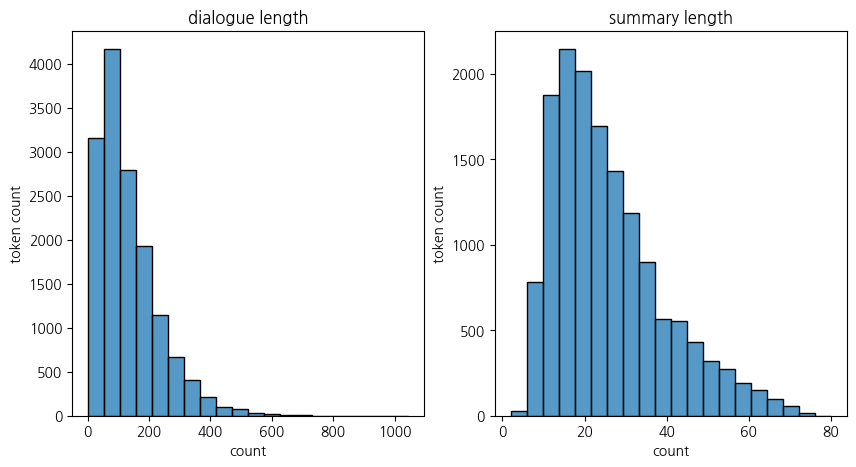

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,2, figsize=(10,5))


sns.histplot(dia_lens, bins=20, ax = axes[0])
axes[0].set_title("dialogue length"), axes[0].set_xlabel("count"), axes[0].set_ylabel("token count")
sns.histplot(sum_lens, bins=20, ax = axes[1])
axes[1].set_title("summary length"), axes[1].set_xlabel("count") , axes[1].set_ylabel("token count");

- 데이터 전처리 (with collator)

In [10]:
def convert_examples_to_features(batch):
    # 입력 값의 토큰화
    input_encodings = tokenizer(batch["dialogue"], max_length=1024, truncation=True)
    
    # 정답 라벨의 토큰화 : T5 계열은 정답과 입력과의 형식의 차이가 있다.
        # OUTDATED
        # with tokenizer.as_target_tokenizer():
        #     target_encodings = tokenizer(batch["summary"], max_length=128, truncation=True)
        # ------
    target_encodings = tokenizer(text_target=batch["summary"], max_length=128, truncation=True)

    return {"input_ids" : input_encodings["input_ids"],
            "attention_mask" : input_encodings["attention_mask"],
            "labels": target_encodings["input_ids"]}

samsum_dataset_train = samsum_dataset["train"].map(convert_examples_to_features, batched=True)
samsum_dataset_train.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

samsum_dataset_valid = samsum_dataset["validation"].map(convert_examples_to_features, batched=True)
samsum_dataset_valid.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

samsum_dataset_test = samsum_dataset["test"].map(convert_examples_to_features, batched=True)
samsum_dataset_test.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

In [16]:
from transformers import DataCollatorForSeq2Seq, TrainingArguments

data_collator = DataCollatorForSeq2Seq(tokenizer, model="google/pegasus-cnn_dailymail")

train_args = TrainingArguments(
    output_dir="pegasus-samsum",
    num_train_epochs=1,
    warmup_steps=500,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    weight_decay=0.01,
    logging_steps=10,
    push_to_hub=True,
    evaluation_strategy="steps",
    eval_steps=500,
    save_steps=500,
    gradient_accumulation_steps=16 # 누적 그레디언트
)

/home/tommy/anaconda3/envs/transformer/lib/python3.11/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


### Gradient Accumulation

- 장점
    - GPU 제한이 있을때 유리하다.
    - 배치 크기가 커지면 더욱 정확한 결과.
    - 더 큰 모델을 학습 가능하게 해준다
- 단점
    - 훈련 속도 저하
    - 최적화가 비효율적으로 수행된다. (긴 업데이트)
- training_arg 에서의 그래디언트 축적 설명
    ```python
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=16
    ```
    - 배치 크기를 1으로 처리하고, 그래디언트를 누적한다.
    - steps = 16 이므로 16 스텝을 처리한 후 그레디언트 계산 밑 누적(파라미터 업데이트)
- 수식
    - 경사 하강법 : $$\theta = \theta - \eta \cdot \nabla_{\theta} L(\theta)$$
        - 여기서는 배치 1 씩 경사하강
    - 축적 : $$G_{\text{accum}} = \sum_{i=1}^{k} \nabla_{\theta} L_i(\theta)$$
    - 파라미터 업데이트 : $$ \theta = \theta - \eta \cdot \frac{1}{k} \cdot G_{\text{accum}} $$
    - 여기서 $k$ 는 `per_device_train_batch_size`
    - 만약 `batch_size=4` 일때 총 `4*16 = 64` 개의 샘플이후 그래디언트를 평균 내어 업데이트를 수행한다.

In [17]:
from huggingface_hub import login
import json

with open("hf_key_token.json") as f:
    token = json.load(f)["hf_key_token"]

login(token)

In [18]:
from transformers import Trainer, AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained("google/pegasus-cnn_dailymail")

trainer = Trainer(
    model = model, args = train_args,
    tokenizer = tokenizer, data_collator = data_collator,
    train_dataset = samsum_dataset_train,
    eval_dataset = samsum_dataset_valid
);

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_6519/45702053.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [19]:
trainer.train()

/home/tommy/anaconda3/envs/transformer/lib/python3.11/site-packages/transformers/data/data_collator.py:657: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)


Step,Training Loss,Validation Loss
500,1.666900,1.483606


/home/tommy/anaconda3/envs/transformer/lib/python3.11/site-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 128, 'min_length': 32, 'num_beams': 8, 'length_penalty': 0.8}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=920, training_loss=1.8309065518171892, metrics={'train_runtime': 6137.6084, 'train_samples_per_second': 2.4, 'train_steps_per_second': 0.15, 'total_flos': 5528248038285312.0, 'train_loss': 1.8309065518171892, 'epoch': 0.9991854466467553})

In [ ]:
from transformers import pipeline

pegasus = pipeline("summarization", model="tommyjin/pegasus-samsum", device=0)
predicted_from_test = pegasus(samsum_dataset_test["dialogue"])
predicted_from_test = [summary_text["summary_text"] for summary_text in predicted_from_test]

In [60]:
import pandas as pd

pd.DataFrame(data=[eval_rouge(predicted_from_test, samsum_dataset_test["summary"])],
            index=["trained_pegasus"])

,rouge1,rouge2,rougeL,rougeLsum
trained_pegasus,0.439675,0.212841,0.351656,0.351494


- 실제 예측 상황을 보고 결정해야 한다.

In [70]:
i = 10
predicted_from_test[i], samsum_dataset_test["summary"][i]

("Wanda wants to make a party. Gina will take Wanda's father's car and go do groceries with her. Wanda will ask Gina on Friday.",
 "Wanda wants to throw a party. She asks Gina to borrow her father's car and go do groceries together. They set the date for Friday. ")

- 직접 판단한 결과 잘 요약 되었다는 것을 알수 있다.

### finetunning 결과

- predicted :
    Wanda wants to make a party. <br>
    Gina will take Wanda's father's car and go do groceries with her. <br>
    Wanda will ask Gina on Friday." <br>

- label :
    Wanda wants to throw a party. <br>
    She asks Gina to borrow her father's car and go do groceries together. <br>
    They set the date for Friday. <br>